In [12]:
# condact r4
# install.packages("ggupset")
library(ggplot2)
library(tidyverse, warn.conflicts = FALSE)
library(ggupset)
library(here)

macaque_ordered_types = c('GLUT1','GLUT2','GLUT3','GLUT4','GLUT5','GLUT6','GLUT7','GLUT8','GLUT9','GLUT10','GLUT11',
                          'GABA1','GABA2_1','GABA2_2','GABA3','GABA4_2','GABA4_1','GABA5')
new_cell_names = c('Exc-BNC2/HMGA2','Exc-NMUR2/PREX2', 'Exc-NMU/TAC3', 'Exc-TAC3/COL5A2/PLCH1','Exc-LMO3/TRPC3', 'Exc-SKOR2/NELL2', 'Exc-MAF/ADARB2', 'Exc-MAFA/BNC2', 
                  'Exc-NTS/TSHZ2', 'Exc-SNTB1/TRH/DACH1', 'Exc-PBX3/SLIT2', 
                  'Inh-CACNA2D3/TCF4', 'Inh-SORCS1/SDK1', 'Inh-PDZD2/SGCD', 'Inh-NPY/ZIC1', 'Inh-MEF2C/RORB','Inh-NXPH1/SDK2','Inh-PDYN/PTPRK')

names(new_cell_names) = macaque_ordered_types
new_cell_nicknames = c('Exc-BNC2','Exc-NMUR2', 'Exc-NMU', 'Exc-TAC3','Exc-LMO3', 'Exc-SKOR2', 'Exc-MAF', 'Exc-MAFA', 
                  'Exc-NTS', 'Exc-SNTB1', 'Exc-PBX3', 'Inh-CACNA2D3', 'Inh-SORCS1', 'Inh-PDZD2', 'Inh-NPY', 'Inh-MEF2C','Inh-NXPH1','Inh-PDYN')
names(new_cell_nicknames) = macaque_ordered_types

In [2]:
genelist_path = here('data/tidy_data/celltype_specific_enhancers/tables/gene-based-ldsc-mouse/')

genelists <- list()
filenames = list.files(path = genelist_path,pattern = "\\.csv$")
for (ii in 1:length(filenames)){
    filename = filenames[ii]
    df <- read.csv(  paste0(genelist_path, filename),header = FALSE  )
    genelist = df[,1]
    
    genelists[[ii]] = genelist
    
    
    }
allgenes = unique(Reduce(c,genelists))

In [3]:
length(allgenes)

[1] 11276

In [3]:
## go through genes and find which cell types match

which_celltype_list <- list()

for (gene_dex in 1:length(allgenes) ){
    
    gene = allgenes[gene_dex]
    
    which_celltypes <- list()
    which_dex = 1
    for (ii in 1:length(filenames)){
        
        filename = filenames[ii]
        celltype = sub('.csv', '', filename)
    
        genelist = genelists[[ii]]
        
        if (gene %in% genelist){
            which_celltypes[[which_dex]] =celltype
            which_dex = which_dex + 1

        }
    }
    
    which_celltype_list[[gene_dex]] <- unlist(which_celltypes)   
}

In [4]:
which_neuron_list <- list()


keep_genes <- list()
keep_gene_dex = 1
for (gene_dex in 1:length(allgenes) ){
    
    gene = allgenes[gene_dex]
    
    which_neurons <- list()
    which_dex = 1
    for (ii in 1:length(filenames)){
        
        filename = filenames[ii]
        celltype = sub('.csv', '', filename)
    
        genelist = genelists[[ii]]
        
        if (gene %in% genelist){
            
            # are they neurons of interest
            if (grepl('GABA',celltype) || grepl('GLUT', celltype)){
                which_neurons[[which_dex]] = celltype
                which_dex = which_dex + 1
                
                }

        }
    }
    if (length(which_neurons) > 0){
        keep_genes[keep_gene_dex] = gene
        which_neuron_list[[keep_gene_dex]] <- unlist(which_neurons) 
        keep_gene_dex = keep_gene_dex + 1
        
        }
  
}

In [76]:
upset_df <- data.frame(unlist(allgenes))
upset_df$celltypes <- which_celltype_list
colnames(upset_df) <- c('gene', 'celltypes')

In [120]:
which_neurons

list()

In [119]:
which_neuron_list[1:5] == NULL

logical(0)

In [45]:
upset_df_neurons <- data.frame(unlist(keep_genes))
upset_df_neurons$celltypes <- which_neuron_list
colnames(upset_df_neurons) <- c('gene', 'celltypes')

In [78]:
head(upset_df)

,gene,celltypes
,<chr>,<list>
1,ITGB4,"Astrocyte1, Astrocyte2, Ependymal , Meninges , Schwann"
2,SLC14A1,"Astrocyte1, Astrocyte2"
3,MYBPC1,"Astrocyte1, Astrocyte2"
4,GRAMD2B,"Astrocyte1, Astrocyte2, Meninges , Microglia , Oligo1 , OPC"
5,ALDH1A1,"Astrocyte1, Astrocyte2, Schwann"
6,SPARCL1,"Astrocyte1, Astrocyte2, Ependymal , GABA1 , Meninges , OPC"


In [102]:
upset_df_test = upset_df[1:500,]

In [5]:
### for each neuron, get total genes and genes shared

# loop through cells
unique_gene_counts = list()

gene_counts = list()
for (ii in 1:length(filenames)){
    unique_gene_counts[[ii]] = -1
    gene_counts[[ii]] = -1
    
    filename = filenames[ii]
    celltype = sub('.csv', '', filename)
    
    names(unique_gene_counts)[ii] = celltype
    names(gene_counts)[ii] = celltype
    
    # it's a neuron of interest - only then look for other genes
    if (grepl('GABA',celltype) || grepl('GLUT', celltype)){
        
        genelist = genelists[[ii]]
        unique_gene_counts[[ii]] = 0
        gene_counts[[ii]] = length(genelist)
    
    # look for every gene in other lists
    for (gene in genelist){
        
        gene_solo = TRUE
        for (jj in 1:length(filenames)){
            filename = filenames[jj]
            celltype2 = sub('.csv', '', filename)

            # a different neuron
            if (  (jj != ii) && (grepl('GABA',celltype2) || grepl('GLUT', celltype2))   ){
                
                other_genelist = genelists[[jj]]
                if (gene %in% other_genelist){
                    
                    gene_solo = FALSE
                    break
                    
                    }
                
            }
        }
        
        ###
        if (gene_solo == TRUE){
            unique_gene_counts[[ii]] = unique_gene_counts[[ii]] + 1
        
            }
    }
        
        
        
        
    }
    
}

In [6]:
unique_gene_counts

$Astrocyte1
[1] -1

$Astrocyte2
[1] -1

$Ependymal
[1] -1

$GABA1
[1] 150

$GABA2_1
[1] 68

$GABA2_2
[1] 47

$GABA3
[1] 75

$GABA4_1
[1] 109

$GABA4_2
[1] 60

$GABA5
[1] 126

$GLUT1
[1] 92

$GLUT10
[1] 16

$GLUT11
[1] 114

$GLUT2
[1] 144

$GLUT3
[1] 96

$GLUT4
[1] 19

$GLUT5
[1] 145

$GLUT6
[1] 51

$GLUT7
[1] 139

$GLUT8
[1] 32

$GLUT9
[1] 51

$Meninges
[1] -1

$Microglia
[1] -1

$midVen
[1] -1

$Oligo1
[1] -1

$Oligo2
[1] -1

$OPC
[1] -1

$Schwann
[1] -1

In [8]:
cell = rep(unique(names(gene_counts)), times = 1, each = 2)
condition = rep(c("unique" , "shared") , length(unique(names(gene_counts))))

combined_gene_list = list()
for (ii in 1:length(gene_counts)){
    
    combined_gene_list[[2*ii-1]] = unique_gene_counts[[ii]]
    combined_gene_list[[2*ii]] = gene_counts[[ii]] - unique_gene_counts[[ii]]
    
    
    }

combined_gene_values = as.numeric(combined_gene_list)

neuron_indices = sort(c(which(grepl('GABA',cell)), which(grepl('GLUT', cell)) ))


cell = cell[neuron_indices]
condition = condition[neuron_indices]
combined_gene_values = combined_gene_values[neuron_indices]

data <- data.frame(cell,condition,combined_gene_values)
data$nickname = factor(new_cell_nicknames[data$cell], new_cell_nicknames)


In [34]:

 
# Stacked
p<- ggplot(data, aes(fill=condition, y=combined_gene_values, x=nickname)) + 
    geom_bar(position="stack", stat="identity") +
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + labs(x = 'Cell Type', y = 'Number of Marker Genes used in LDSC', fill='')


pdf(file = here('figures/exploratory/genebased_gwas_enrichments_mouse/plots/stacked_bar_neurons.pdf'),   # The directory you want to save the file in
    width = 5, # The width of the plot in inches
    height = 4) # The height of the plot in inches
print(p)
dev.off()

png 
  2

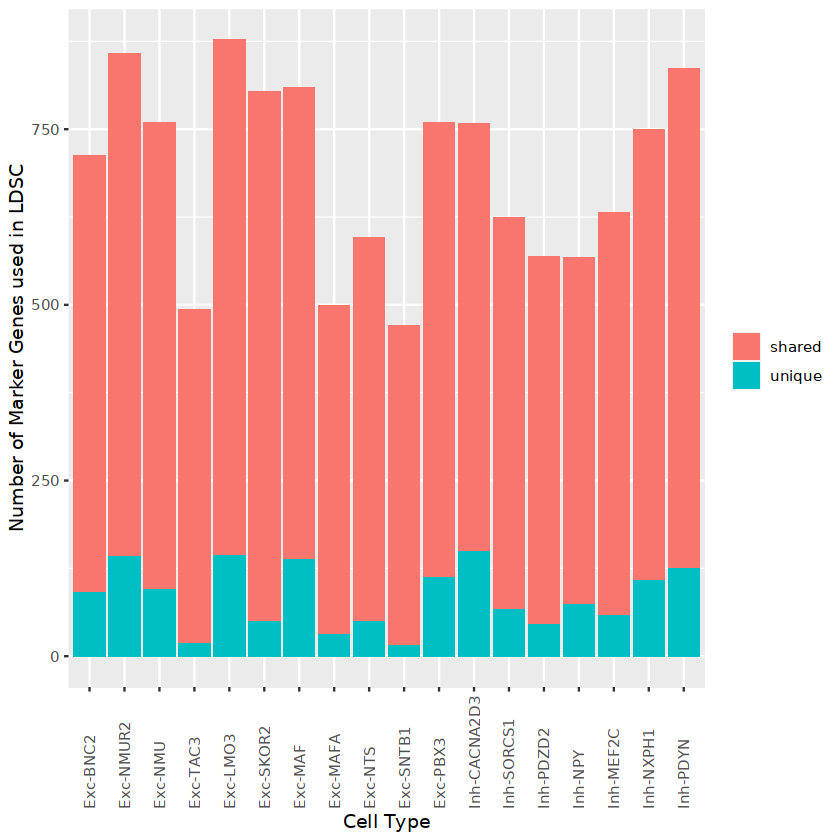

In [33]:
p